## 2 - Comparing Different Playing Strategies

In this section, I go through a few different potential playing strategies for blackjack and offer an analysis on each of them. Namely, the 3 strategies I will test are a Discrete Standing Strategy, a Stochastic Standing Strategy, and probably the most well-known and mathematically proven strategy in Blackjack, the "Basic Strategy." (Another more complex strategy based off of Basic Strategy involves a concept called "card counting" which I will not be showing.)

From this point onwards, in order to test out different strategies as well as train the reinforcement learning algorithm, I use the approach of Monte Carlo simulations to gauge the performance of a strategy. Monte Carlo simulations are extremely useful for situations where normal probability calculations would prove excessive and almost impossible. For example, calculating the probability of picking a Diamond from a deck of cards simply requires knowledge about the cards contained in the deck, however, calculating the expected outcome of a strategy in a round of Blackjack involves numerous uncotrollable uncertainties. As a result, we can run a large number of trials on every strategy and take an average to find a rough estimate for our expected winnings.

Each strategy will be tested by running 100,000 trials of 1 round of Blackjack and taking the mean gain/loss from a 100 dollar bet.

In [1]:
import sys
sys.path.append('../src/')
sys.path.append('../raw/')

from blackjack_utils import simulation, split_hands

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

### Discrete Standing Strategy

The first strategy uses the idea of defining a fixed value, where if the player's card total is greater than or equal to the specified value, the player must stand. I will test this strategy's efficacy in the range of values between 12 and 19 (inclusive).

In [10]:
avg_net_gains = []

for stand_value in range(12, 20):
    def fixed_stand_strategy(hands, deck, **kwargs):
        while hands[0].value() < stand_value:  # Hit only when under stand value
            deck.deal(hands[0])
        
        return False  # Not doubling down
    
    all_net_gains = []
    
    for trials in tqdm(range(100000)):
        all_net_gains.append(simulation(fixed_stand_strategy))

    avg_net_gains.append(np.mean(all_net_gains))  # Take average of all wins/losses

print(avg_net_gains)

100%|██████████| 100000/100000 [00:05<00:00, 17077.65it/s]

[np.float64(-10.255), np.float64(-9.412), np.float64(-8.639), np.float64(-8.057), np.float64(-7.948), np.float64(-8.015), np.float64(-11.751), np.float64(-20.232)]


Text(0.5, 1.0, 'Average Loss Per 100 Dollar Bet with Different Discrete Standing Strategies')

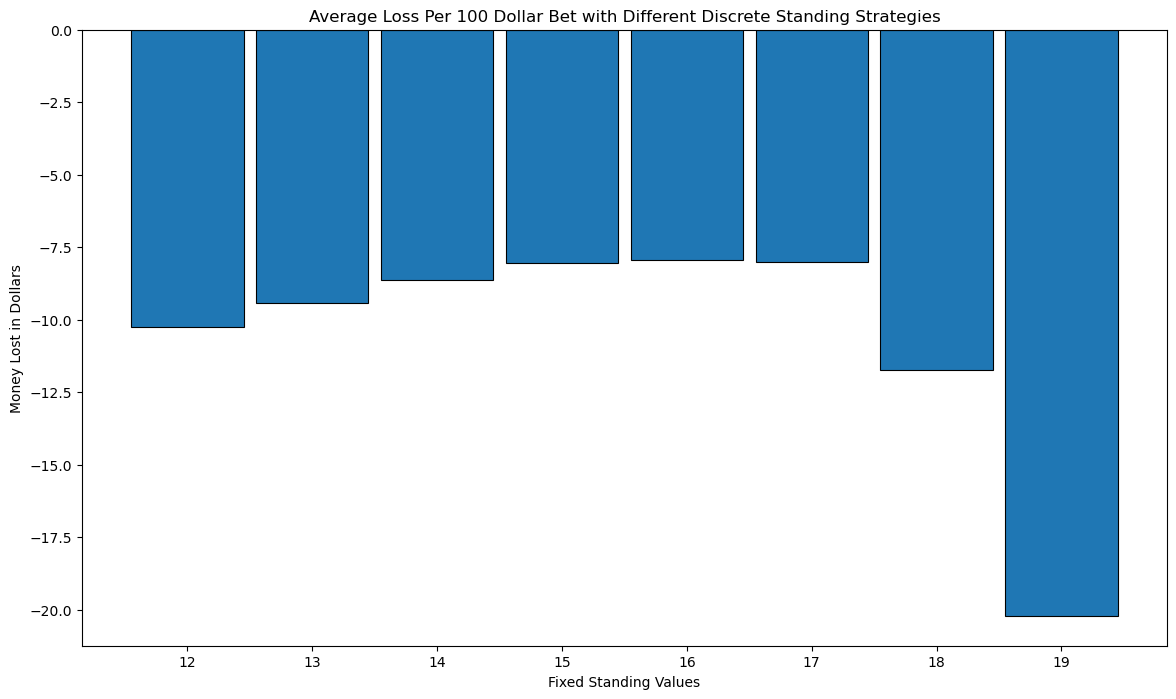

In [11]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(np.arange(12, 20), avg_net_gains, width=0.9, edgecolor="black", linewidth=0.8)
ax.set_xlabel('Fixed Standing Values')
ax.set_ylabel('Money Lost in Dollars')
ax.set_title('Average Loss Per 100 Dollar Bet with Different Discrete Standing Strategies')

As can be seen from the graph above, it seems that the best predicted range for standing is around the 15-17 mark. At a standing value of 16, the average net gain per 100 dollar bet is estimated to be around -$7.95.

### Stochastic Standing Strategy

The next strategy is based off of a probabilistic and randomized approach. I have taken the 3 best performing standing values from the previous strategy and now applied stochasticity to whether we should hit or stand. For example, in the previous strategy, if the card total was below our fixed standing value, then we would hit 100% of the time and stand 0% of the time, and if the card total was above our fixed standing value, we would hit 0% of the time and stand 100% of the time.

The purpose of this strategy is to test whether it would be better to add variation to when we stand or hit. I am testing 4 different stand/hit probabilities at 0.7/0.3, 0.8/0.2, 0.9/0.1, and finally, 1.0/0.0 (which is what the previous strategy assumes).

In [4]:
avg_net_gains = []

standing_values = [15, 16, 17]
probabilities = [(0.7, 0.3), (0.8, 0.2), (0.9, 0.1), (1.0, 0.0)]

for stand_value in standing_values:
    for hit_prob, stand_prob in probabilities:
        def stochastic_stand_strategy(hands, deck, **kwargs):
            while True:
                if hands[0].value() < stand_value:
                    # When we are below standing value, we hit with
                    # the first probability or else we stand
                    if np.random.rand() < hit_prob:
                        deck.deal(hands[0])
                    else:
                        break
                elif hands[0].value() < 21:
                    # When we are above standing value but haven't
                    # busted, we hit with the second probability or
                    # else we stand
                    if np.random.rand() < stand_prob:
                        deck.deal(hands[0])
                    else:
                        break
                else:
                    break
                    
            return False  # Not doubling down
        
        all_net_gains = []
        
        for trials in tqdm(range(100000)):
            all_net_gains.append(simulation(stochastic_stand_strategy))
        
        avg_net_gains.append(np.mean(all_net_gains))  # Take average of all wins/losses

print(avg_net_gains)

100%|██████████| 100000/100000 [00:05<00:00, 17195.62it/s]

[np.float64(-23.049), np.float64(-17.726), np.float64(-12.873), np.float64(-7.899), np.float64(-23.173), np.float64(-18.379), np.float64(-13.115), np.float64(-8.165), np.float64(-23.898), np.float64(-19.57), np.float64(-14.397), np.float64(-8.358)]


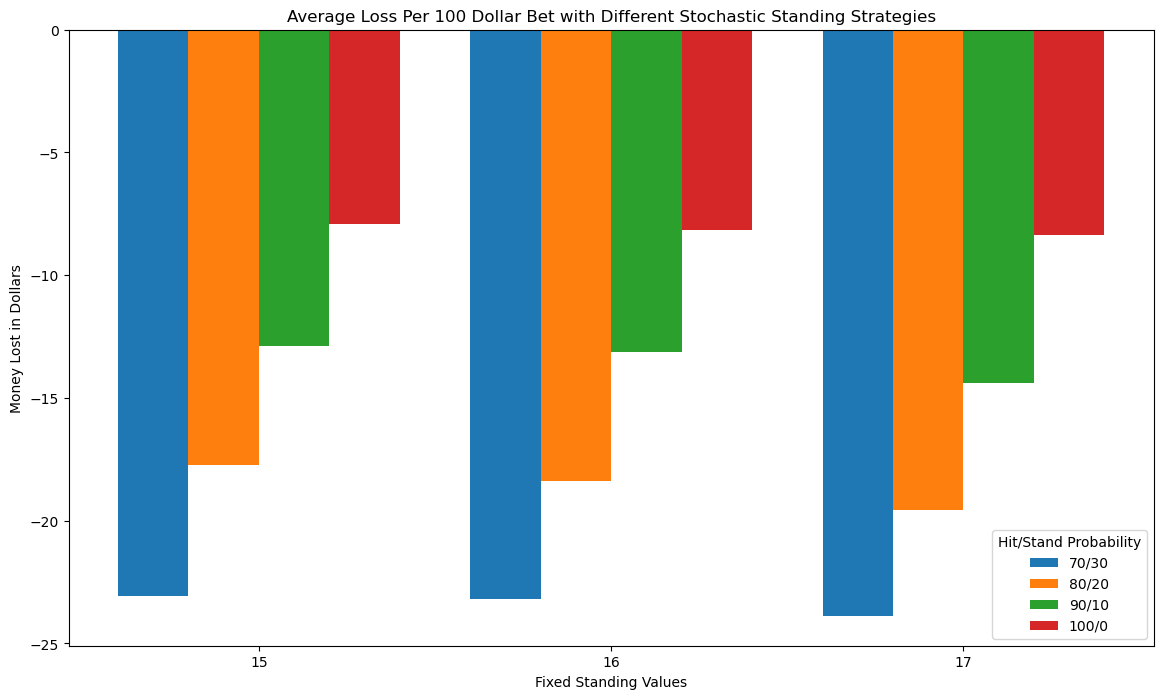

In [6]:
fig, ax = plt.subplots(figsize=(14, 8))

prob_labels = ["70/30", "80/20", "90/10", "100/0"]

num_bars_per_value = 4
bar_width = 0.2
x = np.arange(len(standing_values))

for i, prob_label in enumerate(prob_labels):
    bar_positions = x + (i - 1.5) * bar_width
    bar_heights = avg_net_gains[i::num_bars_per_value]
    ax.bar(bar_positions, bar_heights, bar_width, label=prob_label)

ax.set_xticks(x, standing_values)
ax.set_xlabel('Fixed Standing Values')
ax.set_ylabel('Money Lost in Dollars')
ax.set_title('Average Loss Per 100 Dollar Bet with Different Stochastic Standing Strategies')
ax.legend(title='Hit/Stand Probability')

#### Discrete vs. Stochastic

From the last plot, we can make out that there are some clear differences between the discrete and stochastic strategies. The glaringly obvious discovery is that the stochastic strategy seems to perform significantly worse as the hitting and standing process gets more randomized. The 100/0 group from the fixed standing strategy performs a staggering 5 dollars better than the next best option, with a hit/stand probability of 90/10. In terms of casinos, this loss is a huge deal, as losing an average of 13 dollars per 100 dollar bet translates to the house having a 13% edge over the player, instead of the 8% from the fixed standing values.

The reason for this discrepancy is that the stochastic strategy randomly introduces bad decisions into our play. For example, the stochastic decision process might cause a hand to hit even after reaching a high value such as 20, or it might cause a hand to stand while still being at a low value such as 10. This inconsistent decision-making in a binary setting results in the suboptimal performances piling up overtime, and creates an unpredictable strategy that doesn't produce as favorable results as the fixed standing strategy does.

### Basic Strategy

The last 2 strategies only took into account the current hand that the player had, but it didn't consider one crucial piece of information: the dealer's up-card. When hands are dealt in Blackjack, the dealer deals 2 cards to themself, the first of which is placed facing upwards and the second downwards. Using the information provided by the dealer's up-card, it is possible to create a strategy to decipher what the best course of action is in every possible situation.

Mathematician Edward Thorp did exactly that when he developed the Basic Strategy. The image below depicts the action that yields the best probability at every observed hand for the player as well as every possible dealer's up-card. This strategy reportedly reduces the casino's edge to a mere 0.5%, meaning that using our 100 dollar bet amount, the average net loss per round should come out to only -$0.50.

<img src="https://www.techopedia.com/wp-content/uploads/2023/04/TECHOPEDIA-DEALERS-CARD-TABLE.png" alt="Blackjack basic strategy chart" width="600" /> <br>
*Image credit: [Techopedia](https://www.techopedia.com/gambling-guides/blackjack-strategy)*

First, we recreate the table above, using tuples for doubling down or splitting actions which are only allowed on the first turn of our simulation.

In [2]:
# Representing the options with numbers 0-3
# Hit = 0, Stand = 1, Split = 2, Double Down = 3
# If double down or split is possible and best choice,
# represent option from table as tuple i.e. D/H = (3, 0)

# If the card total <= 8, always hit
card_total_table = {
    9: [0, (3, 0), (3, 0), (3, 0), (3, 0), 0, 0, 0, 0, 0],
    10: [(3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), 0, 0],
    11: [(3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0)],
    12: [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    13: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    14: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    15: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    16: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
}
# If the card total >= 17, always stand

ace_table = {
    2: [0, 0, 0, (3, 0), (3, 0), 0, 0, 0, 0, 0],
    3: [0, 0, 0, (3, 0), (3, 0), 0, 0, 0, 0, 0],
    4: [0, 0, (3, 0), (3, 0), (3, 0), 0, 0, 0, 0, 0],
    5: [0, 0, (3, 0), (3, 0), (3, 0), 0, 0, 0, 0, 0],
    6: [0, (3, 0), (3, 0), (3, 0), (3, 0), 0, 0, 0, 0, 0],
    7: [1, (3, 1), (3, 1), (3, 1), (3, 1), 1, 1, 0, 0, 0],
}
# If the card with the ace is >= 8, always stand

# If can't split (not first deal) then play considering card total
pair_table = {
    2: [0, 0, (2, 0), (2, 0), (2, 0), (2, 0), 0, 0, 0, 0],
    3: [0, 0, (2, 0), (2, 0), (2, 0), (2, 0), 0, 0, 0, 0],
    4: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    5: [(3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), 0, 0],
    6: [0, (2, 0), (2, 1), (2, 1), (2, 1), 0, 0, 0, 0, 0],
    7: [(2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 0), 0, 0, 0, 0],
    8: [(2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 0), (2, 0), (2, 0), (2, 0), (2, 0)],
    9: [(2, 1), (2, 1), (2, 1), (2, 1), (2, 1), 1, (2, 1), (2, 1), 1, 1],
    10: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    11: [(2, 0), (2, 0), (2, 1), (2, 1), (2, 1), (2, 0), (2, 0), (2, 0), (2, 0), (2, 0)]
}

# To default to standing if no matches in the above tables
stand_list = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Next, we make a function to decipher which action to use in what situation based on the tables above.

In [22]:
def get_action(hand, dealer_upcard, first_option):
    action = None
    
    if hand[0] == hand[1]:
        # Have to subtract 2 for proper indexing
        # Blackjack card values go from 2-11, table goes from 0-9
        action = pair_table[hand[0].value][dealer_upcard.value - 2]
    elif hand[0].value == 11:
        # If the first card is ace and second is not

        # When the other card value is not in the ace table
        # dictionary, that means we should stand
        action = ace_table.get(hand[1].value, stand_list)[dealer_upcard.value - 2]
    elif hand[1].value == 11:
        # If the second card is ace and first is not
        action = ace_table.get(hand[0].value, stand_list)[dealer_upcard.value - 2]
    elif hand.value() <= 8:
        # Always hit when card total <= 8
        action = 0
    elif hand.value() >= 17:
        # Always stand when card total >= 17
        action = 1
    else:
        # If the card total is between 9-16 (inclusive)
        action = card_total_table[hand.value()][dealer_upcard.value - 2]
    
    if isinstance(action, tuple):
        # If we get a tuple and we have enough money and it is
        # the first deal, we can pick the first option
        if first_option:
            return action[0]
        
        # Otherwise, it is not the first deal but we still
        # received a tuple, so pick second option
        return action[1]
    
    return action
    

Finally, we play out the strategy for the player's hand, accounting for different situations such as doubling down or splitting hands.

In [23]:
def basic_strategy(player_hands, shoe, dealer_upcard, can_bet_more):
    # When dealt first hand, the choice to pick first option only
    # depends on whether we have the money to double down or split
    action = get_action(player_hands[0], dealer_upcard, can_bet_more)

    if action == 0:
        # Action was hitting, so draw a card and keep playing
        shoe.deal(player_hands[0])
    elif action == 1:
        # Action was standing, so return false
        return False
    elif action == 2:
        # Action was splitting, so split hands and keep playing
        split_hands(player_hands, shoe)
    else:
        # Action was doubling down, so draw a card and return true
        shoe.deal(player_hands[0])
        return True
    
    for hand in player_hands:
        # Resetting action for multiple hands
        action = -1

        while hand.value() <= 20 and action != 1:
            # Since it is not the first turn anymore, we cannot split or double down
            action = get_action(hand, dealer_upcard, False)

            if action == 0:
                shoe.deal(hand)

    return False

In [24]:
all_net_gains = []

for trials in tqdm(range(100000)):
    all_net_gains.append(simulation(basic_strategy))
        
avg_net_gain = np.mean(all_net_gains)

print(avg_net_gain)

100%|██████████| 100000/100000 [00:06<00:00, 16544.52it/s]


-6.488


After testing, we see that the Basic Strategy yields an average -$6.49 net gain on every 100 dollar bet, which is definitely an improvement from both our previous strategies. However, this also means that our expected house edge is about 6.5% as opposed to our hypothesized 0.5% from above.

There are multiple reasons as to why our results don't match the expected house edge. First of all, our setup and rules are different from the assumptions made by Edward Thorp's chart. Our rules don't allow the player to resplit or double down after the first split, and there is no surrendering or putting down insurance on a hand. Secondly, the expected outcome might be different depending on the number of decks we choose to use for our shoe, or our set deck penetration limit of 0.25. But the most important reason for this discrepancy is that our simulation gives a 1:1 payout on wins via getting a Blackjack (total value of 21). In order to incentivize players, most casinos offer favorable odds for winning via a Blackjack hand, some paying 6:5, or even 3:2. The calculated 0.5% house edge uses a 3:2 Blackjack payout, which means that if a player bets a 100 dollars like in our situation, they would win back 150 for a Blackjack hand win. These reasons all together explain why we're simulating a much higher house edge.